# Load Packages

What we can recall from critisicm regarding this presentation:

- did not take the equal weighted as benchmark
- use total return indices (I think)

In [242]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import math
from scipy.stats import skew, kurtosis

# Seaborn
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# little function for later
def isNaN(string):
    return string != string

# Plotstyle

In [243]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Load Data

In [244]:
# rawdata is direct import from excel

# Import of excel data, sheet by sheet
xls_ETF = pd.ExcelFile("1_Data/Data Clean TM/Data_ETFxIndex_stiched.xlsx")
xls_Inflation = pd.ExcelFile("1_Data/Data Clean TM/Data_Inflation.xlsx")
xls_Yield = pd.ExcelFile("1_Data/Data Clean TM/Yields_Clean_TM.xlsx")
xls_FX = pd.ExcelFile("1_Data/Data Clean TM/Data_FX_spot.xlsx")

ETF_raw = pd.DataFrame(pd.read_excel(xls_ETF))
Inflation_raw = pd.DataFrame(pd.read_excel(xls_Inflation, 2))
Yield_long_raw = pd.DataFrame(pd.read_excel(xls_Yield, 2))
Yield_short_raw = pd.DataFrame(pd.read_excel(xls_Yield, 3))
FX_raw = pd.DataFrame(pd.read_excel(xls_FX, 3))

# keep a safe copy of the rawdata to compare the changes
ETF = ETF_raw.copy()
Inflation = Inflation_raw.copy()
Yield_long = Yield_long_raw.copy()
Yield_short = Yield_short_raw.copy()
FX = FX_raw.copy()

# Set date as index
ETF.set_index("Datum", inplace=True)
Inflation.set_index("Datum", inplace=True)
Yield_long.set_index("Datum", inplace=True)
Yield_short.set_index("Datum", inplace=True)
FX.set_index("Dates", inplace=True)

In [245]:
# Drop all the columns in which only text is and safe them separately --> ONLY RUN ONCE
# ETF_text = ETF.iloc[0,:]
# Yield_text = Yield.iloc[0,:]
# Yield_short_text = Yield_short.iloc[0,:]
# cpicore_text = cpicore.iloc[0:1,:]
# ETF.drop([0], inplace = True)
# Yield.drop([0], inplace = True)
# Yield_short.drop([0], inplace = True)
# cpicore.drop([0,1], inplace = True)

# Universal Variables

In [246]:
tCost = 0.005 # Needs to be discussed !!

# Universal Functions

In [247]:
def computeTurnover(previousWeights, newWeights, assetReturns, Rf):
    """
    Computes turnover by comparing the previous and the new target weights 
    of the portfolio, accounting for the returns on the assets. The function 
    also computes the portfolio return excluding transaction costs, Rp. 

    Parameters:
        previousWeights (array-like): previous target weights of the portfolio
        newWeights (array-like): new target weights of the portfolio
        assetReturns (array-like): returns on the assets
        Rf (float): risk-free rate of return

    Returns:
        turnover (float): turnover
        Rp (float): portfolio return excluding transaction costs
    """

    Rp = np.sum(np.multiply(previousWeights, assetReturns)) + (1 - np.sum(previousWeights)) * Rf
    valuePerAsset = previousWeights * (1 + assetReturns)
    currentWeights = valuePerAsset / (1 + Rp)
    turnover = np.sum(np.abs(newWeights - currentWeights))

    return turnover, Rp

In [248]:
# def summarize_performance(xs_returns, rf, factor_xs_returns, annualization_factor, txt):
#     # Compute total returns
#     n_assets = xs_returns.shape[1]
#     total_returns = xs_returns + rf * np.ones((xs_returns.shape[0], n_assets))

#     # Compute the terminal value of the portfolios to get the geometric mean
#     # return per period
#     n_periods = xs_returns.shape[0]
#     final_pf_val_rf = np.prod(1 + rf)
#     final_pf_val_total_ret = np.prod(1 + total_returns)
#     geom_avg_rf = 100 * ((final_pf_val_rf ** (annualization_factor / n_periods)) - 1)
#     geom_avg_total_return = 100 * ((final_pf_val_total_ret ** (annualization_factor / n_periods)) - 1)
#     geom_avg_xs_return = geom_avg_total_return - geom_avg_rf

#     # Regress returns on benchmark to get alpha and factor exposures
#     X = np.column_stack((np.ones(n_periods), factor_xs_returns))
#     b = np.linalg.lstsq(X, xs_returns, rcond=None)[0]
#     betas = b[1:, :]

#     # Based on the regression estimates, compute the total return on the passive
#     # alternative and the annualized alpha
#     bm_ret = np.dot(factor_xs_returns, betas) + rf * np.ones((n_periods, n_assets))
#     final_pf_val_bm = np.prod(1 + bm_ret)
#     geom_avg_bm_return = 100 * ((final_pf_val_bm ** (annualization_factor / n_periods)) - 1)
#     alpha_geometric = geom_avg_total_return - geom_avg_bm_return

#     # Rescale the returns to be in percentage points
#     xs_returns = 100 * xs_returns
#     total_returns = 100 * total_returns

#     # Compute first three autocorrelations
#     ac1 = np.diag(np.corrcoef(xs_returns[:-1, :], xs_returns[1:, :], rowvar=False)[:n_assets, n_assets:])
#     ac2 = np.diag(np.corrcoef(xs_returns[:-2, :], xs_returns[2:, :], rowvar=False)[:n_assets, n_assets:])
#     ac3 = np.diag(np.corrcoef(xs_returns[:-3, :], xs_returns[3:, :], rowvar=False)[:n_assets, n_assets:])

#     # Report the statistics
#     print(f'Performance Statistics for {txt}')
#     arithm_avg_total_return = annualization_factor * np.mean(total_returns)
#     arithm_avg_xs_return = annualization_factor * np.mean(xs_returns)
#     std_xs_returns = np.sqrt(annualization_factor) * np.std(xs_returns, ddof=1)
#     sharpe_arithmetic = arithm_avg_xs_return / std_xs_returns
#     print(f'ArithmAvgTotalReturn: {arithm_avg_total_return}')
#     print(f'ArithmAvgXsReturn: {arithm_avg_xs_return}')
#     print(f'StdXsReturns: {std_xs_returns}')
#     print(f'SharpeArithmetic: {sharpe_arithmetic}')
#     print(f'GeomAvgTotalReturn: {geom_avg_total_return}')
#     print(f'GeomAvgXsReturn: {geom_avg_xs_return}')
#     sharpe_geometric = geom_avg_xs_return / std_xs_returns
#     print(f'SharpeGeometric: {sharpe_geometric}')
#     print(f'MinXsReturn: {np.min(xs_returns, axis=0)}')
#     print(f'MaxXsReturn: {np.max(xs_returns, axis=0)}')


In [249]:
def summarize_performance2(xs_returns, rf, factor_xs_returns, annualization_factor, txt):
    # Compute total returns
    n_assets = xs_returns.shape[1]
    rf_reshaped = rf.values.reshape((-1,1))
    total_returns = xs_returns + rf_reshaped * np.ones((xs_returns.shape[0], n_assets))

    # Compute the terminal value of the portfolios to get the geometric mean
    # return per period
    n_periods = xs_returns.shape[0]
    final_pf_val_rf = np.prod(1 + rf_reshaped)
    final_pf_val_total_ret = np.prod(1 + total_returns)
    geom_avg_rf = 100 * ((final_pf_val_rf ** (annualization_factor / n_periods)) - 1)
    geom_avg_total_return = 100 * ((final_pf_val_total_ret ** (annualization_factor / n_periods)) - 1)
    geom_avg_xs_return = geom_avg_total_return - geom_avg_rf

    # Regress returns on benchmark to get alpha and factor exposures
    X = np.column_stack((np.ones(n_periods), factor_xs_returns))
    b = np.linalg.lstsq(X, xs_returns, rcond=None)[0]
    betas = b[1:, :]

    # Based on the regression estimates, compute the total return on the passive
    # alternative and the annualized alpha
    bm_ret = np.dot(np.array(factor_xs_returns).reshape(-1, 1), betas) + rf_reshaped * np.ones((n_periods, n_assets))
    final_pf_val_bm = np.prod(1 + bm_ret)
    geom_avg_bm_return = 100 * ((final_pf_val_bm ** (annualization_factor / n_periods)) - 1)
    alpha_geometric = geom_avg_total_return - geom_avg_bm_return

    # Rescale the returns to be in percentage points
    xs_returns = 100 * xs_returns
    total_returns = 100 * total_returns

    # Report the statistics
    print(f'Performance Statistics for {txt}')
    arithm_avg_total_return = annualization_factor * np.mean(total_returns)
    arithm_avg_xs_return = annualization_factor * np.mean(xs_returns)
    std_xs_returns = np.sqrt(annualization_factor) * np.std(xs_returns, ddof=1)
    sharpe_arithmetic = arithm_avg_xs_return / std_xs_returns
    print(f'ArithmAvgTotalReturn: {arithm_avg_total_return}')
    print(f'ArithmAvgXsReturn: {arithm_avg_xs_return}')
    print(f'StdXsReturns: {std_xs_returns}')
    print(f'SharpeArithmetic: {sharpe_arithmetic}')
    print(f'GeomAvgTotalReturn: {geom_avg_total_return}')
    print(f'GeomAvgXsReturn: {geom_avg_xs_return}')
    sharpe_geometric = geom_avg_xs_return / std_xs_returns
    print(f'SharpeGeometric: {sharpe_geometric}')
    print(f'MinXsReturn: {np.min(xs_returns, axis=0)}')
    print(f'MaxXsReturn: {np.max(xs_returns, axis=0)}')


# Value

Recent infl – the average of the headline and core annual CPI inflation rate
--> we don't have headline inflation


Effective target infl - The effective inflation target is the mean of the target range announced or implied by the authorities plus an adjusted for past “target misses”, which is the last 3 years’ average gap between actual inflation and the target means
--> we don't have target rates for all countries --> use 2.5 as target rate

Formula: (1/n)*recent infl + ((n-1)/n)*effective target infl

In [250]:
# first we will take the difference between the effective target (mean) inflation and the actual inflation

cpiheadline = Inflation.copy()

eff_target_diff = pd.DataFrame(columns = cpiheadline.columns, index = cpiheadline.index)

for i in eff_target_diff.columns:
    if i == "Australia":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.025
    elif i == "Canada":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "China":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Germany":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "France":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "UK":
        eff_target_diff.loc[:"2003-11-28",i] = cpiheadline.loc[:"2003-11-28",i] - 0.025
        eff_target_diff.loc["2003-12-31":,i] = cpiheadline.loc["2003-12-31":,i] - 0.02
    elif i == "Italy":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Japan":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.033
    elif i == "Singapore":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "USA":
        eff_target_diff.loc[:"2011-12-31",i] = cpiheadline.loc[:"2011-12-31",i] - 0.0185
        eff_target_diff.loc["2012-01-31":,i] = cpiheadline.loc["2012-01-31":,i] - 0.02
    elif i == "Spain":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Switzerland":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.01
    elif i == "India":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.04

In [251]:
np.nanmean(eff_target_diff.loc[:"2002-11-30", "Singapore"])
#np.nanmean(eff_target_diff.loc["2020-04-30":, "Singapore"])

-0.012722222222222225

In [252]:
# create the rolling 3-year average of the core inflation

# first I have to set up an empty dictionary to store the rolling averages
cpiheadline_avg = {}
for i in cpiheadline.columns:
    cpiheadline_avg[i] = []

# next up we iterate over the cpicore data to get the index and safe them in the dictionary
runner = len(cpiheadline.index)
for i in cpiheadline.index:
    if runner == 35:
        break
    
    for j,k in enumerate(cpiheadline.columns):
        inflation = np.nanmean(eff_target_diff.iloc[runner-36:runner, j])
        cpiheadline_avg[k].insert(0, inflation)
    runner -= 1
    
#cpiheadline_avg
cpiheadline_avg_trimmed = pd.DataFrame(cpiheadline_avg)

AttributeError: 'float' object has no attribute 'dtype'

In [ ]:
cpiheadline_avg_trimmed # until here I checked several times whether it is correct and it seems to work

In [ ]:
# now we calculate the value formula:
# (1/n)*recent inflation + ((n-1)/n)*effective target inflation for the years: 2, 5, 10, 20, 30

# first we need to align the dataframes 
cpiheadline_trimmed = cpiheadline[35:]
cpiheadline_avg_trimmed.set_index(cpiheadline_trimmed.index, inplace = True)

# second we create an empty dictionary to fill with the calculations
formula_values = {}
x = 0
for i in cpiheadline_trimmed.columns:
    x += 1
    for j in [2,5,10,20,30]:
        formula_values[f"{i},{j}"] = []
formula_values = pd.DataFrame(columns = formula_values.keys(), index = cpiheadline_trimmed.index)


# now that we have the empty dictionary to fill, we start with caluclating the inflation expectation
for i,k in enumerate (cpiheadline_trimmed.columns):
    for j,m in enumerate([2,5,10,20,30]):
        formula_values.iloc[:,j+i*5] = (1/m)*cpiheadline_trimmed[k] +((m-1)/m)*cpiheadline_avg_trimmed[k]
        
#formula_values

<ipython-input-5-90c02453a451>:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  formula_values.iloc[:,j+i*5] = (1/m)*cpiheadline_trimmed[k] +((m-1)/m)*cpiheadline_avg_trimmed[k]


In [ ]:
# now we need to align the NA's from the ETF with the NA's from the Yields such that we don't get a weight for a date that
# we don't have return data for

Yield_na = Yield_long.copy()
ETF_na = ETF.pct_change().isna()
ETF_na
runner = 0
counter = 0
for i,k in enumerate(Yield_na.columns):
    if counter == 5:
        counter = 0
        runner += 1
    tmp = ETF_na.iloc[:,runner]
    Yield_na.iloc[tmp,i] = np.nan
    counter +=1
Yield_na


# now we have the issue that the Yield_clean data and the Inflation_clean data doesn't have the same sequence of countries
# to avoid this we resort the Yield_clean data to fit the Inflation_clean data

clean_names = ["Germany", "France","Spain","Italy","United Kingdom", "Switzerland", "China", "Australia", "Japan", "USA", "Canada", "Singapore", "India"]

# we split the dataframe into the different countries...
Germany = Yield_na.iloc[:,:5]
France = Yield_na.iloc[:,5:10]
Spain = Yield_na.iloc[:,10:15]
Italy = Yield_na.iloc[:,15:20]
UK = Yield_na.iloc[:,20:25]
Switzerland = Yield_na.iloc[:,25:30]
China = Yield_na.iloc[:,30:35]
Australia = Yield_na.iloc[:,35:40]
Japan = Yield_na.iloc[:,40:45]
USA = Yield_na.iloc[:,45:50]
Canada = Yield_na.iloc[:,50:55]
Singapore = Yield_na.iloc[:,55:60]
India = Yield_na.iloc[:,60:]

# ... and fusion them together to have the same order as the Inflation data (plus dividing by 100 to have same level as Inflation)
Yields_aligned = [India, Singapore, Canada, USA, Japan, Australia, China, Switzerland, UK, Spain, France, Germany, Italy]
Yields_aligned = pd.concat(Yields_aligned, axis=1)
Yields_aligned = Yields_aligned /100
#Yields_aligned

In [ ]:
# in a next step we adjust the yield data to have the same lookback as the other data

Yield_trimmed = Yields_aligned[35:]

Real_yield = pd.DataFrame(0, columns = formula_values.columns, index = formula_values.index)

# now we take the difference between yield etf and inflation
for i,k in enumerate(formula_values.columns):
    for j,l in enumerate(formula_values.index):
        Real_yield.iloc[j,i] = Yield_trimmed.iloc[j,i] - formula_values.iloc[j,i]
#Real_yield

In [ ]:
# in a final step we will average over the duration of the countries to get one average for each country

Real_yield_avg = pd.DataFrame(columns = cpiheadline_avg_trimmed.columns, index = Real_yield.index)

runner = 0
for i in range(0, len(Yields_aligned.columns)-1, 5):
    temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))
    Real_yield_avg.iloc[:,runner] = temp.values
    runner +=1
    
#Real_yield_avg

<ipython-input-8-1ebfb3f6f625>:7: RuntimeWarning: Mean of empty slice
  temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))
<ipython-input-8-1ebfb3f6f625>:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Real_yield_avg.iloc[:,runner] = temp.values
<ipython-input-8-1ebfb3f6f625>:7: RuntimeWarning: Mean of empty slice
  temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))


# Momentum

In [ ]:
# Create Monthly Returns out of ETF Prices
ETF_price = ETF.copy()
ETF_returns = ETF_price.pct_change()
ETF_ret = ETF_returns.tail(-1)
rf = Yield_short.iloc[:,0] / 100

## Weights Momentum

In [ ]:
# Create Weights for Momentum

# Prep Work
nAssets = len(ETF_price.columns) # 13 Countries
nMonths = len(ETF_price) # 280 Months of prices (31.12.1999 - 31.03.2023)
lookbackStart = 12
lookbackEnd = 1
firstMonth = lookbackStart + 1 # we can only start computing weights in 13.month bc we have 12 months lookback 
nLongs = 5
nShorts = 5
momLongWeights = pd.DataFrame(np.zeros((nMonths, nAssets)))
momLSWeights = pd.DataFrame(np.zeros((nMonths, nAssets)))
long_weight = np.divide(1,nLongs)
short_weight = np.divide(1,nShorts)*(-1)

 # Loop to get the Long weights and the Long/Short Weights
for month in range(firstMonth, nMonths):
     pastReturns = pd.DataFrame(np.divide(ETF_price.iloc[month - lookbackEnd, :], ETF_price.iloc[month - lookbackStart, :]) - 1)
     highReturns = pastReturns.nlargest(nLongs,columns=pastReturns.columns)
     lowReturns = pastReturns.nsmallest(nShorts,columns=pastReturns.columns)
     low_index = lowReturns.index
     high_index = highReturns.index
     pRet_index = pastReturns.index

     high_index_numbers = pRet_index.get_indexer(high_index)
     low_index_numbers = pRet_index.get_indexer(low_index)
     # Long Weights only
     momLongWeights.iloc[month,high_index_numbers] = long_weight
     # Long/Short Weights only
     momLSWeights.iloc[month,high_index_numbers] = long_weight
     momLSWeights.iloc[month,low_index_numbers] = short_weight

# Set Index and Column Names again
momLongWeights = momLongWeights.set_index(ETF_price.index).copy()
momLongWeights.columns = ETF_price.columns
momLSWeights = momLSWeights.set_index(ETF_price.index).copy()
momLSWeights.columns = ETF_price.columns

In [ ]:
# Data Cleanup -> Returns in sync with weights!
momLongWeights_cut = momLongWeights.iloc[firstMonth:, :] # cut out first 13 months -> first row now is weight calculated at 31.01.2000; keep extra row at end for Turnover
momLSWeights_cut = momLSWeights.iloc[firstMonth:, :] # cut out first 13 months -> first row now is weight calculated at 31.01.2000; keep extra row at end for Turnover
ETF_ret_cut = ETF_ret.iloc[firstMonth :, :] #we need Returns from 28.02.2000
rf_cut_mom = rf.iloc[firstMonth+1:]
dates4Fig = ETF_ret_cut.index
nMonths_actual = nMonths - (firstMonth+1)

In [ ]:
# Calculate Strategy Returns with No Transaction Cost
# note we only take weights rows until end -1 bc we left one to much in
LongStratRet = np.sum(np.multiply(ETF_ret_cut, momLongWeights_cut.iloc[ : -1, :]), axis=1)
LSStratRet = np.sum(np.multiply(ETF_ret_cut, momLSWeights_cut.iloc[ : -1, :]), axis=1) + rf_cut_mom
stratReturnsNoTC = pd.concat([LongStratRet,LSStratRet], axis=1)
stratReturnsNoTC = stratReturnsNoTC.set_axis(['Long_Mom_NoTC','LS_Mom_NoTC'], axis=1)

/var/folders/p7/g7d04mzx5wn88jp9x3dzpb9w0000gn/T/ipykernel_41276/1728815470.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  LongStratRet = np.sum(np.multiply(ETF_ret_cut, momLongWeights_cut.iloc[ : -1, :]), axis=1)
/var/folders/p7/g7d04mzx5wn88jp9x3dzpb9w0000gn/T/ipykernel_41276/1728815470.py:4: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Seri

## Turnover Momentum

In [ ]:
## Compute Turnover for Momentum
turnover_mom = np.zeros((nMonths_actual, 2))
stratReturnsTC = np.zeros((nMonths_actual, 2))

for month in range(0, nMonths_actual):
    currentRf = rf_cut_mom.iloc[month]
    currentRet = ETF_ret_cut.iloc[month, :]
    turnover_mom[month, 0] = computeTurnover(momLongWeights_cut.iloc[month, :], momLongWeights_cut.iloc[month + 1, :], currentRet, currentRf)[0]
    turnover_mom[month, 1] = computeTurnover(momLSWeights_cut.iloc[month, :], momLSWeights_cut.iloc[month + 1, :], currentRet, currentRf)[0]
    #print("Current value of month is:", month)

avgTurnover_Longmom = np.mean(turnover_mom[:,0])
avgTurnover_LSmom = np.mean(turnover_mom[:,1])
print("Avg Turnover of LongMom is:", avgTurnover_Longmom)
print("Avg Turnover of LSMom is:", avgTurnover_LSmom)

stratReturnsTC = stratReturnsNoTC - (tCost * turnover_mom)
stratReturnsTC = stratReturnsTC.set_axis(['Long_Mom_TC','LS_Mom_TC'], axis=1)

Avg Turnover of LongMom is: 0.30282071674871947
Avg Turnover of LSMom is: 0.6268675075436647


## Summary Statistics Momentum

In [ ]:
# Get Summary Statistics
# Prep Work
annualizationFactor = 12
# All Total Returns
allTotalReturns_mom = pd.concat([stratReturnsNoTC,stratReturnsTC], axis=1)
# All Excess Returns
rf_cut_mom_matrix = pd.concat([rf_cut_mom,rf_cut_mom,rf_cut_mom,rf_cut_mom], axis=1)
allXsReturns_mom = np.subtract(allTotalReturns_mom , rf_cut_mom_matrix)

summarize_performance2(allXsReturns_mom, rf_cut_mom, allXsReturns_mom.iloc[:,0], annualizationFactor, 'Long_Mom_NoTC, LS_Mom_NoTC, Long_Mom_TC, LS_Mom_TC')



/var/folders/p7/g7d04mzx5wn88jp9x3dzpb9w0000gn/T/ipykernel_41276/1414548367.py:8: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  allXsReturns_mom = np.subtract(allTotalReturns_mom , rf_cut_mom_matrix)


## Plot Momentum

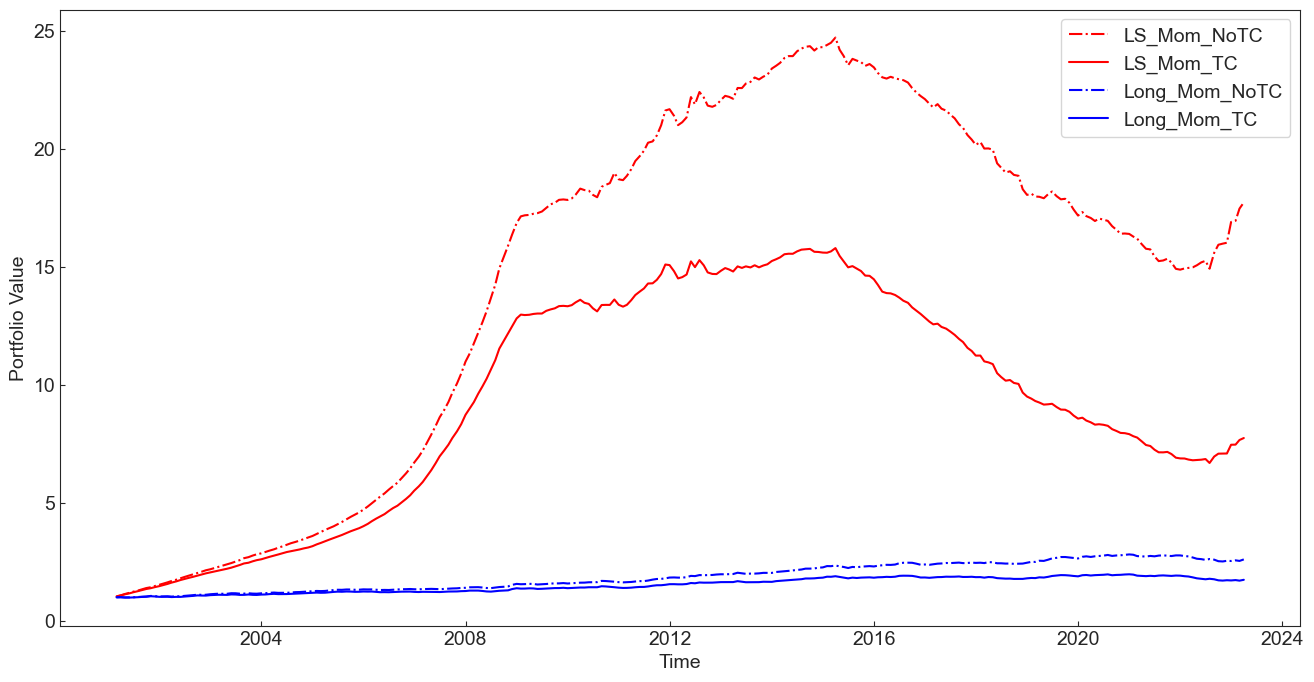

In [ ]:
# Plot Strategy Performances
strategyNAV_mom = np.cumprod(1 + allTotalReturns_mom)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,1], label='LS_Mom_NoTC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,3], label='LS_Mom_TC',color="red")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,0], label='Long_Mom_NoTC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,2], label='Long_Mom_TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
summarize_performance2(allXsReturns_mom, rf_cut_mom, allXsReturns_mom.iloc[:,0], annualizationFactor, 'Long_Mom_NoTC, LS_Mom_NoTC, Long_Mom_TC, LS_Mom_TC')


Performance Statistics for Long_Mom_NoTC, LS_Mom_NoTC, Long_Mom_TC, LS_Mom_TC
ArithmAvgTotalReturn: Long_Mom_NoTC     4.400238
LS_Mom_NoTC      13.235228
Long_Mom_TC       2.583314
LS_Mom_TC         9.474023
dtype: float64
ArithmAvgXsReturn: Long_Mom_NoTC   -7.163747
LS_Mom_NoTC      1.671243
Long_Mom_TC     -8.980671
LS_Mom_TC       -2.089962
dtype: float64
StdXsReturns: Long_Mom_NoTC    6.662062
LS_Mom_NoTC      2.959029
Long_Mom_TC      6.614448
LS_Mom_TC        2.999575
dtype: float64
SharpeArithmetic: Long_Mom_NoTC   -1.075305
LS_Mom_NoTC      0.564794
Long_Mom_TC     -1.357735
LS_Mom_TC       -0.696753
dtype: float64
GeomAvgTotalReturn: Long_Mom_NoTC     4.423138
LS_Mom_NoTC      13.849815
Long_Mom_TC       2.548494
LS_Mom_TC         9.678639
dtype: float64
GeomAvgXsReturn: Long_Mom_NoTC   -7.587497
LS_Mom_NoTC      1.839180
Long_Mom_TC     -9.462141
LS_Mom_TC       -2.331997
dtype: float64
SharpeGeometric: Long_Mom_NoTC   -1.138911
LS_Mom_NoTC      0.621549
Long_Mom_TC     -1.43

/Users/thomas/opt/anaconda3/envs/pmp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# Carry

In [253]:
# for carry we will now calculate the differences between the long-term yields (2,5,10,20,30) and short-term yields (1M, 3M)
# we will create a dataframe for the 1M and the 3M
# I take the Yield_na for the calculation to get the same NA's as the ETF has

Carry_3m = pd.DataFrame(columns = Yield_long.columns, index = Yield_long.index)
avg_Carry_3m = pd.DataFrame(0, columns = Yield_short.columns, index = Yield_short.index)

runner = 0
counter = 0
for i in range(0,len(Yield_long.columns)):
    if counter == 5:
        runner += 1
        counter = 0
    Carry_3m.iloc[:,i] = Yield_na.iloc[:,i] - Yield_short.iloc[:,runner]
    counter += 1
    
for i in range(0,len(Yield_short.columns)):
    avg_Carry_3m.iloc[:,i] = np.nanmean([Carry_3m.iloc[:,i*5], Carry_3m.iloc[:,i*5+1], Carry_3m.iloc[:,i*5+2], Carry_3m.iloc[:,i*5+3], Carry_3m.iloc[:,i*5+4]], axis = 0)

avg_Carry_3m = avg_Carry_3m / 100

NameError: name 'Yield_na' is not defined

# Sort function to create the buckets

In [ ]:
def pmp_Sort(sort_variable, n_longs, n_shorts, long_high_values=1, equal_weights_ls=False):
    """
    Generates portfolio weights based on sort_variable. The function ignores assets for which the sort variable is
    missing (NaN). All such assets get a weight of zero in the portfolio. n_longs and n_shorts denote the number of
    assets held long and short. When long_high_values is True, assets that have the highest values for sort_variable
    are held long and those with the lowest values are held short. Otherwise, the opposite holds.
    """
    # Find the assets with the highest and lowest values of the sort variable
    if long_high_values:
        sort_variable_sorted = sort_variable  # For long high values, sort descending
    else:
        sort_variable_sorted = -sort_variable   # For long low values, sort ascending
    non_nan_assets = ~np.isnan(sort_variable_sorted)
    non_nan_count = np.count_nonzero(non_nan_assets)
    
    # Check if n_shorts is zero
    if n_shorts == 0:
        tmp_long = list(sort_variable_sorted)
        tmp_long = [-10000000 if pd.isna(x) else x for x in tmp_long]
        list_of_longs = np.argsort(tmp_long)[-5:]
        
        weights = np.zeros(len(sort_variable))
        weights[list_of_longs] = 1 / n_longs
        return weights

    # If n_shorts is not zero, handle normally
    if non_nan_count < n_longs:
        n_longs = non_nan_count
        n_shorts = 0
    elif n_shorts > 0 and non_nan_count < n_longs + n_shorts:
        n_shorts = non_nan_count - n_longs
        
    if equal_weights_ls == True:
        n_shorts = non_nan_count // 2
        n_longs = non_nan_count // 2
        
    

    tmp_long = list(sort_variable_sorted)
    tmp_long = [-10000000 if pd.isna(x) else x for x in tmp_long]
    list_of_longs = np.argsort(tmp_long)[-5:]
        
    tmp_short = list(sort_variable_sorted)
    tmp_short = [100000000 if pd.isna(x) else x for x in tmp_short]
    list_of_shorts = np.argsort(tmp_short)[:5]
    

    # Assign the weights to assets in the list of longs and shorts
    n_assets = len(sort_variable)
    weights = np.zeros(n_assets)
    weights[list_of_longs] = 1 / n_longs
    weights[list_of_shorts] = -1 / n_shorts

    return weights


In [ ]:
# Value
weights = pd.DataFrame(columns = Real_yield_avg.columns, index = Real_yield_avg.index)

for i,k in enumerate(Real_yield_avg.index):
    temp = pmp_Sort(Real_yield_avg.iloc[i,:], 5,5)
    weights.iloc[i,:] = temp
    
# now we need to align the columns of weights to columns of returns
ETF_returns = ETF.pct_change()
ETF_value = ETF_returns.iloc[35:,:]
ETF_value.rename(columns = {"Swiss comb": "Switzerland"}, inplace=True)

Value_weights = pd.DataFrame(columns = ETF_value.columns, index = ETF_value.index)
weights.set_index(ETF_value.index, inplace=True)
for i in ETF_value.columns:
    Value_weights.loc[:,i] = weights.loc[:,i]

#Value_weights

<ipython-input-27-59ec5279197b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETF_value.rename(columns = {"Swiss comb": "Switzerland"}, inplace=True)


In [ ]:
# Momentum

In [ ]:
# Carry
Carry_weights = pd.DataFrame(columns = avg_Carry_3m.columns, index = avg_Carry_3m.index)

for i,k in enumerate(avg_Carry_3m.index):
    if i == 0:
        continue
    temp = pmp_Sort(avg_Carry_3m.iloc[i,:], 5, 5)
    Carry_weights.iloc[i,:] = temp

#Carry_weights

# PF weights (not yet working)

In [ ]:
# in the following we will combine the weight matrices that we've gathered sofar into two distinct weight matrices for the PF
# the PF_weight_score will be a number between -3 and 3 indicating the signals suggesting the country
# the PF_weight will just be the sum of the weights

PF_weights = Value_weights + Carry_weights

# now we will create the scored weights
PF_score = pd.DataFrame(columns = Value_weights.columns, index = Value_weights.index)
PF_weights_score = pd.DataFrame(columns = Value_weights.columns, index = Value_weights.index)

value_pos = Value_weights > 0
value_neg = Value_weights < 0
carry_pos = Carry_weights > 0
carry_neg = Carry_weights < 0

PF_score[value_pos] = 1
PF_score[value_neg] = -1
PF_score[carry_pos] += 1
PF_score[carry_neg] -= 1

# print(PF_weights)
# print(PF_weights_score)

# now we will create the weights for the PF_weights_score
x = PF_score > 0
y = PF_score < 0
PF_pos = PF_score[x]
PF_neg = PF_score[y]

for i,k in enumerate(PF_pos.index):
    pos = sum(PF_pos.iloc[i,:]>0)
    if pos == 0:
        continue
    pos = 1/pos
    
    neg = sum(PF_score.iloc[i,:]<0)
    if neg == 0:
        continue
    neg = -1/neg
    
    PF_weights_score.iloc[i,:] = PF_pos.iloc[i,:] * pos
    PF_weights_score.iloc[i,:] = PF_neg.iloc[i,:] * neg
    
    

In [ ]:
PF_weights_score

,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
2002-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.666667,NaN,NaN,NaN,0.333333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.666667,NaN,NaN,NaN,0.333333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-31,0.666667,NaN,NaN,NaN,0.333333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Return calculation

In [ ]:
# now that we have the weights of the different strategies and the returns of the ETF's we can calculate the returns

# Value

# first we need to align the length of the dataframes and the columns of the two dataframes to match each other
Value_returns = Value_weights.mul(ETF_value)
#Value_returns

# Value_returns_2 = pd.DataFrame(columns = Value_weights.columns, index = ETF_value.index)
# for i,k in enumerate(Value_weights.columns):
#     Value_returns_2.iloc[:,i] = ETF_value.iloc[:,i] * Value_weights.iloc[:,i]
# Value_returns_2.tail(10)

In [ ]:
Carry_returns = Carry_weights.mul(ETF_returns)
#Carry_returns

# Transaction cost

In [ ]:
# we will be using the ETF_returns, and the respective weights for the calcuclation of the transaction costs
# furthermore we need the return of the whole portfolio to calculate the TC

# Converting returns to Euro

# Benchmarking

In [ ]:
benchmark = df[["MSCI_EU"]]
benchmark = benchmark.loc["1999-12-31 00:00:00":"2022-09-30 00:00:00"]
benchmark

In [ ]:
bm_mtl_ret = mtl_ret = benchmark.pct_change().resample("M").agg(lambda x: (1+x).prod()-1) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
bm_mtl_ret


In [ ]:
#compare momentum result vs benchmark
comparison = pd.DataFrame(bm_mtl_ret)
comparison["mom_ret"] = profits
comparison.rename(columns={ comparison.columns[0]: "bench_ret" }, inplace = True)
comparison["bench_indexed"] = comparison["bench_ret"].add(1).cumprod()
comparison["mom_indexed"] = comparison["mom_ret"].add(1).cumprod()
comparison


In [ ]:
comparison

# Comparison Plot

In [ ]:
# Plotting
fig, ax = plt.subplots()
ax.plot(comparison.index,comparison.mom_indexed, label="Momentum", color="red")
ax.plot(comparison.index,comparison.bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns')
ax.set_title("Momentum long/short 5 sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999")